<a href="https://colab.research.google.com/github/BoshiLee/pytorch_learning/blob/main/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch torchvision

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

`dset.MNIST(root, train=True, transform=None, transform=None, download=False)`

参数说明
1. root : processed/training.pt 和 processed/test.pt 的主目录
2. train : True = 训练集, False = 测试集
3. download : True = 从互联网上下载数据集，并把数据集放在root目录下. 如果数据集之前下载过，将处理过的数据（minist.py中有相关函数）放在processed文件夹下。
4. transform：對影像進行的處理

[其他資料集](https://codingdict.com/sources/py/torchvision.datasets/15805.html)

## 下載 Data 並實作歸一轉換

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)) 
                                ]) #把灰階從0~255壓縮到0~1
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

## training_loader 將 60000 筆圖像資料分成 600 個 batch

In [4]:
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

## 轉換圖片回可以被 pyplot 使用的格式

先前轉換 tensor 的方法，現在再轉換回去
![](https://imgur.com/MNL0WoI.jpg)

In [5]:
def img_conver(tensor: torch.Tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((1, 1, 1)) #將原本用 0~1 表達的灰階轉換爲 [c, h, w]
  image = image.clip(0, 1)
  return image

## 畫出 Dataset 的模樣

![](https://imgur.com/E99GZVX.jpg)

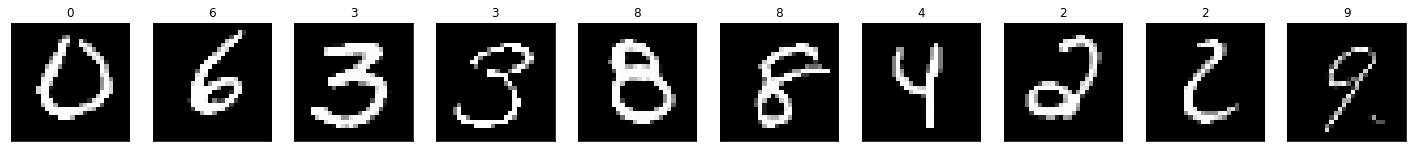

In [6]:
data_iter = iter(training_loader)
(images, labels) = data_iter.next()
fig = plt.figure(figsize=(25, 6))
for idx in np.arange(10):
  ax = fig.add_subplot(2, 10, idx+1) #
  con_im = img_conver(images[idx])
  plt.imshow(con_im)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(label=labels[idx].item())

![log](https://imgur.com/bYArXJf.jpg)



```
nn.CrossEntropyLoss()
```

该损失函数结合了nn.LogSoftmax()和nn.NLLLoss()两个函数。它在做分类（具体几类）训练的时候是非常有用的。在训练过程中，对于每个类分配权值，可选的参数权值应该是一个1D张量。当你有一个不平衡的训练集时，这是是非常有用的。那么针对这个函数，下面将做详细的介绍。

[nn.CrossEntropyLoss() 介紹](https://zhuanlan.zhihu.com/p/98785902)



In [7]:
class Classfier(nn.Module):
  def __init__(self, D_in, H1, H2, D_out):
    super().__init__();
    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, D_out)
  
  def forward(self, x):
    x = F.relu(self.linear1(x)) # 輸入位給第一層 hidden layer 後再將輸出給下一層用
    x = F.relu(self.linear2(x)) # 輸入位給第二層 hidden layer 給輸出曾使用
    x = self.linear3(x) # 這裡不用 softmax 去做分類，課程是說等等可以用原始輸出給 nn.CrossEntropyLoss
    return x


## initail classfier
28 * 28 = 784 個數入端
h1 125 個節點
h2 65 個節點
最後輸出 10 個的機率

In [8]:
model = Classfier(784, 125, 65, 10) 
model

Classfier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

## Training

In [10]:
epochs = 15

running_loss_history = []
running_correct_history = []
val_running_loss_history = []
val_running_correct_history = []

def validation_process():
  correct = 0.0
  with torch.no_grad():
    for (val_inputs, val_labels) in validation_loader:
      val_inputs = val_inputs.view(val_inputs.shape[0], -1) # 如果是torch.view(a, -1)，则原张量会变成一维的结构。
      val_outputs = model.forward(val_inputs)
      val_loss = criterion(val_outputs, val_labels) #loss function

      _, val_preds = torch.max(val_outputs, 1) #返回每一列中最大值的那个元素，且返回索引（返回最大元素在这一列的行索引）
      val_loss += val_loss.item() # 將每一訓練完的結果加回總數
      correct += torch.sum(val_preds == val_labels.data)
    return val_loss, correct

def record_epoch(title:str, losses, corrects, loader_lenth):
    epoch_loss = losses / loader_lenth # 將損失總數除上一個 batch 的資料總數就可以到此次 batch 訓練出來損失多少
    epoch_accuracy = corrects.float() / loader_lenth

    print(title + " loss: {:.4f}".format(epoch_loss))
    print(title + " accuracy: {:.4f}".format(epoch_accuracy.item()))

    return epoch_loss, epoch_accuracy


def traing_process():
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  for (inputs, labels) in training_loader:
    inputs = inputs.view(inputs.shape[0], -1) # 如果是torch.view(a, -1)，则原张量会变成一维的结构。
    outputs = model.forward(inputs)
    loss = criterion(outputs, labels) #loss function
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    _, preds = torch.max(outputs, 1) #返回每一列中最大值的那个元素，且返回索引（返回最大元素在这一列的行索引）
    running_loss += loss.item() # 將每一訓練完的結果加回總數
    running_corrects += torch.sum(preds == labels.data)
  else:
    
    val_running_loss, val_running_corrects = validation_process()
    training_epoch_loss, training_epoch_accuracy = record_epoch(
        title="Training",
        losses=running_loss,
        corrects=running_corrects,
        loader_lenth=len(training_loader)
        )
    
    running_loss_history.append(training_epoch_loss)
    running_correct_history.append(training_epoch_accuracy)
    
    val_epoch_loss, val_epoch_accuracy = record_epoch(
        title='Validation',
        losses=val_running_loss,
        corrects=val_running_corrects,
        loader_lenth=len(validation_loader)
        )
    
    val_running_loss_history.append(val_epoch_loss)
    val_running_correct_history.append(val_epoch_accuracy)

for e in range(epochs):
  traing_process()

Training loss: 0.9475
Training accuracy: 77.3217
Validation loss: 0.0126
Validation accuracy: 88.4700
Training loss: 0.3822
Training accuracy: 89.1933
Validation loss: 0.0097
Validation accuracy: 90.6600
Training loss: 0.3195
Training accuracy: 90.7050
Validation loss: 0.0088
Validation accuracy: 91.8500
Training loss: 0.2871
Training accuracy: 91.6900
Validation loss: 0.0081
Validation accuracy: 92.2500
Training loss: 0.2600
Training accuracy: 92.4150
Validation loss: 0.0073
Validation accuracy: 92.8200
Training loss: 0.2365
Training accuracy: 93.1650
Validation loss: 0.0063
Validation accuracy: 93.6600
Training loss: 0.2156
Training accuracy: 93.7233
Validation loss: 0.0057
Validation accuracy: 94.1400
Training loss: 0.1981
Training accuracy: 94.2283
Validation loss: 0.0052
Validation accuracy: 94.5700
Training loss: 0.1823
Training accuracy: 94.6783
Validation loss: 0.0046
Validation accuracy: 94.8200
Training loss: 0.1685
Training accuracy: 95.0967
Validation loss: 0.0045
Validatio

**output ＝ 輸出預測原始分數結果**

[[ 1.2261069e+00 -5.7273965e+00 -4.1954031e+00 -3.6484995e+00
  -2.4565067e+00  1.3545682e+00  1.0387512e+01 -5.3805690e+00
   3.3601427e-01 -1.1107481e+01]
 [-1.3542774e+00 -1.5277462e+00 -3.5840625e-01 -5.0116652e-01
  -1.1355836e+00 -2.6571882e-01 -3.0248828e+00 -8.7250930e-01
   1.0844460e+00  8.2059675e-01]
 [ 1.0535399e+01 -2.8152704e+01 -8.2211943e+00 -1.5631153e+01
  -2.3035938e+01 -1.1812346e+01 -7.9027677e+00 -1.6740650e+01
  -9.5602045e+00 -6.5746822e+00]
 [ 1.6841581e+00 -4.0459881e+00 -5.2802405e+00 -3.5284595e+00
  -2.3374493e+00  1.3500847e+00  6.1499205e+00 -3.8639560e+00
   1.1507473e+00 -4.3945112e+00]
 [-3.8497939e+00 -1.0161068e+00 -1.2596358e+00  2.0538642e+00
  -2.2537014e+00  5.8658910e-01 -2.4626253e+00 -4.6215944e+00
   1.3722317e+00 -2.1360791e+00]
 [-5.1659923e+00 -6.8063464e+00 -2.8562734e+00 -2.0882232e+00
   3.8221255e-01 -2.9005632e+00 -1.3687369e+01  2.3450470e+00
  -9.0407890e-01  4.9399509e+00]
 [-4.0788898e+00 -3.7877328e+00 -1.4883008e+00  1.4184544e+00
  -5.2517614e+00 -2.2519267e+00 -1.5924767e+01  4.3276215e+00
  -1.1257372e+00  3.2146273e+00]
 [-7.7456293e+00 -7.5740331e-01  2.4926439e-02  7.7191372e+00
  -3.8455017e+00  8.3695984e-01 -1.0358748e+01 -3.1360974e+00
   1.6302195e+00  7.6127601e-01]
 [ 8.8252964e+00 -2.6196466e+01 -6.6488318e+00 -1.5089152e+01
  -2.0039001e+01 -1.1642657e+01 -7.0557885e+00 -1.6164896e+01
  -8.5983057e+00 -6.5639067e+00]
 [-3.0094376e+00 -2.9393325e+00 -1.1140752e+00 -1.6939263e+00
  -6.2546844e+00 -5.3861895e+00 -2.0039701e+01  9.1067991e+00
  -3.3135712e+00  2.5666628e+00]]

**pred = 取出最大的分數，表示 model 預測的結果，可以跟 label 比對**

[6 8 0 6 3 9 7 3 0 7]

比對方法

![比對方法](https://imgur.com/FgDRHIT.jpg)

## 繪製訓練 Loss

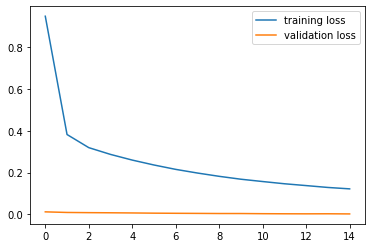

In [11]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()
plt.show()

## 繪製訓練準確率

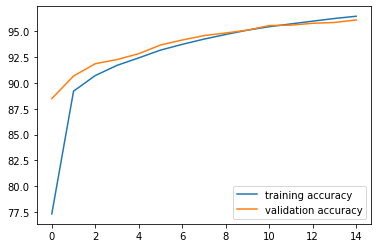

In [14]:
plt.plot(running_correct_history, label='training accuracy')
plt.plot(val_running_correct_history, label='validation accuracy')
plt.legend()
plt.show()

# 語法解釋

### PIL.Image/numpy.ndarray与Tensor的相互转换
PIL.Image/numpy.ndarray转化为Tensor，常常用在训练模型阶段的数据读取，而Tensor转化为PIL.Image/numpy.ndarray则用在验证模型阶段的数据输出。

我们可以使用 transforms.ToTensor() 将 PIL.Image/numpy.ndarray 数据进转化为torch.FloadTensor，并归一化到[0, 1.0]：

*(C= chanel, H= height, W=width)*

取值范围为[0, 255]的PIL.Image，转换成形状为[C, H, W]，取值范围是[0, 1.0]的torch.FloadTensor；
形状为[H, W, C]的numpy.ndarray，转换成形状为[C, H, W]，取值范围是[0, 1.0]的torch.FloadTensor。
而transforms.ToPILImage则是将Tensor转化为PIL.Image。如果，我们要将Tensor转化为numpy，只需要使用 .numpy() 即可。如下：

img_path = "./data/img_37.jpg"


```
# transforms.ToTensor()
transform1 = transforms.Compose([
    transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
    ]
)

```

### 归一化
归一化对神经网络的训练是非常重要的，那么我们如何归一化到[-1.0, -1.0]呢？只需要将上面的transform1改为如下所示：



```
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
    ]
)
```


（1）transforms.Compose就是将transforms组合在一起；

（2）transforms.Normalize使用如下公式进行归一化：

channel=（channel-mean）/std

这样一来，我们的数据中的每个值就变成了[-1,1]的数了。



Clip 方法

In [15]:
a = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
a.clip(0, 1) #大於 1 的皆轉為 1

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Cross Entropy Loss 範例

與 MSE 比較與公式：

  MSE 較適用於線性問題

  BCE 較適用於分類問題

![formula](https://imgur.com/JRekF6M.jpg)

m 是 data 的數量

In [16]:
x_input=torch.randn(3,3)#随机生成输入 
print('x_input:\n',x_input) 
y_target=torch.tensor([1,2,0])#设置输出具体值 print('y_target\n',y_target)

#计算输入softmax，此时可以看到每一行加到一起结果都是1
softmax_func=nn.Softmax(dim=1)
soft_output=softmax_func(x_input)
print('soft_output:\n',soft_output)

#在softmax的基础上取log
log_output=torch.log(soft_output)
print('log_output:\n',log_output)

#对比softmax与log的结合与nn.LogSoftmaxloss(负对数似然损失)的输出结果，发现两者是一致的。
logsoftmax_func=nn.LogSoftmax(dim=1)
logsoftmax_output=logsoftmax_func(x_input)
print('logsoftmax_output:\n',logsoftmax_output)

#pytorch中关于NLLLoss的默认参数配置为：reducetion=True、size_average=True
nllloss_func=nn.NLLLoss()
nlloss_output=nllloss_func(logsoftmax_output,y_target)
print('nlloss_output:\n',nlloss_output)

#直接使用pytorch中的loss_func=nn.CrossEntropyLoss()看与经过NLLLoss的计算是不是一样
crossentropyloss=nn.CrossEntropyLoss()
crossentropyloss_output=crossentropyloss(x_input,y_target)
print('crossentropyloss_output:\n',crossentropyloss_output)

x_input:
 tensor([[-0.1624, -2.3504,  0.7471],
        [ 0.3480,  1.5808,  0.9603],
        [-0.1986,  1.7240, -0.7129]])
soft_output:
 tensor([[0.2781, 0.0312, 0.6907],
        [0.1593, 0.5467, 0.2939],
        [0.1185, 0.8106, 0.0709]])
log_output:
 tensor([[-1.2796, -3.4677, -0.3701],
        [-1.8367, -0.6038, -1.2244],
        [-2.1326, -0.2100, -2.6469]])
logsoftmax_output:
 tensor([[-1.2796, -3.4677, -0.3701],
        [-1.8367, -0.6038, -1.2244],
        [-2.1326, -0.2100, -2.6469]])
nlloss_output:
 tensor(2.2749)
crossentropyloss_output:
 tensor(2.2749)


## 改變張量維度語法 view

In [17]:
view_samaple = torch.tensor([[1, 2],
                              [3, 4],
                              [5, 6]])
result = view_samaple.view(2,-1)
result

#由上面的案例可以看到，如果是torch.view(参数a，-1)，则表示在参数b未知，参数a已知的情况下自动补齐列向量长度，在这个例子中a=2，tt3总共由6个元素，则b=6/2=3。

tensor([[1, 2, 3],
        [4, 5, 6]])